In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import gc
import os
import numpy as np
import shutil
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Setting CUDA devices as visible
cuda_devices = "0,1"
# os.environ["CUDA_VISIBLE_DEVICES"] = cuda_devices

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("Using GPUs:")
    for device_id in cuda_devices.split(','):
        device = torch.device(f"cuda:{device_id}")
        print(f"  Device {device_id}: {torch.cuda.get_device_name(int(device_id))}")
else:
    print("Using CPU")

Using GPUs:
  Device 0: Tesla P100-PCIE-16GB
  Device 1: Tesla P100-PCIE-16GB


In [4]:
torch.cuda.empty_cache()
gc.collect()

11

In [5]:
def get_classes(directory):
    class_list = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path) and os.listdir(item_path):
            class_list.append(item)
    return class_list

In [6]:
in_dir = "/mnt/nis_lab_research/data/class_data/neg/far_shah_b1-b5_b8_train_neg_cln"
out_dir = "../../data/classifier/far_shah_b1-b5_b8_train_neg_cln"
num_workers = os.cpu_count() or 32
epochs = 25

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by ResNet
    transforms.ToTensor(),
    # CHANGE TO BE DATA SPECIFIC
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [8]:
def tt_split(input_dir, out_dir, train_ratio):
    """
    Splits the dataset in the given directory into train and test sets.

    :param input_dir: Path to the input directory.
    :param train_ratio: Ratio of train set (between 0 and 1).
    """
    if not 0 <= train_ratio <= 1:
        raise ValueError("Train ratio must be between 0 and 1")

    base_dir = out_dir
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create train and test directories
    for directory in [train_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

    # Process each class directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if os.path.isdir(class_dir):
            # Create class directories in train and test
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Get a list of images and shuffle them
            images = os.listdir(class_dir)
            random.shuffle(images)

            # Split images into train and test
            split_point = int(len(images) * train_ratio)
            train_images = images[:split_point]
            test_images = images[split_point:]

            # Copy images to train and test directories
            for image in train_images:
                shutil.copy2(os.path.join(class_dir, image), os.path.join(train_dir, class_name))
            for image in test_images:
                shutil.copy2(os.path.join(class_dir, image), os.path.join(test_dir, class_name))

In [9]:
class_list = sorted(get_classes(os.path.join(out_dir, "test")))
num_classes = len(class_list)
print(num_classes)
print(class_list)

26
['Accept Button', 'Advertisement', 'Alert Notification', 'Allow Button', 'Checkbox', 'Click Captcha', 'Close Button', 'Download Button', 'Email Input Box', 'General Button', 'General Input Box', 'Login Button', 'Logo', 'Name Input Box', 'Password Input Box', 'Phone Input Box', 'Play Button', 'Popup', 'Random', 'Search Button', 'Search Input Box', 'Submit Button', 'Text Captcha', 'Toggle Button', 'Update Button', 'Video']


In [10]:
if not os.path.exists(out_dir):
    tt_split(in_dir, out_dir, 0.8)

In [11]:
train_set = torchvision.datasets.ImageFolder(root='../../data/classifier/' + in_dir.split("/")[-1] + '/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=num_workers)


In [12]:
test_set = torchvision.datasets.ImageFolder(root='../../data/classifier/' + in_dir.split("/")[-1] + '/test', transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=num_workers)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 27 total classes - text captcha have 0 so it is removed for now
model = model.to(device)
model = nn.DataParallel(model)  # Use DataParallel

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for i, data in progress_bar:
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the primary device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (i + 1))
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
print('Finished Training')

Epoch 1/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.392]

Epoch 1, Loss: 0.39182675032576253



Epoch 2/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.27] 

Epoch 2, Loss: 0.2704400210217996



Epoch 3/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.236]

Epoch 3, Loss: 0.2361660744673809



Epoch 4/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.217]

Epoch 4, Loss: 0.21691435359972566



Epoch 5/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.202]

Epoch 5, Loss: 0.2020960745644682



Epoch 6/25: 100%|██████████| 847/847 [09:44<00:00,  1.45it/s, loss=0.188]

Epoch 6, Loss: 0.18800421221865674



Epoch 7/25: 100%|██████████| 847/847 [09:49<00:00,  1.44it/s, loss=0.173]

Epoch 7, Loss: 0.1732130789559735



Epoch 8/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.158]

Epoch 8, Loss: 0.1578885174610398



Epoch 9/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.144]

Epoch 9, Loss: 0.1435316206696042



Epoch 10/25: 100%|██████████| 847/847 [09:46<00:00,  1.44it/s, loss=0.127]

Epoch 10, Loss: 0.12722653351117194



Epoch 11/25: 100%|██████████| 847/847 [09:46<00:00,  1.44it/s, loss=0.11]  

Epoch 11, Loss: 0.10989509802421614



Epoch 12/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0961]

Epoch 12, Loss: 0.09608872807029428



Epoch 13/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0816]

Epoch 13, Loss: 0.08160722743689029



Epoch 14/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0719]

Epoch 14, Loss: 0.071863659385948



Epoch 15/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0597]

Epoch 15, Loss: 0.05972614795972352



Epoch 16/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.0563]

Epoch 16, Loss: 0.056276624943674



Epoch 17/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0482]

Epoch 17, Loss: 0.048160635507770035



Epoch 18/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0447]

Epoch 18, Loss: 0.04466833772111372



Epoch 19/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.0406]

Epoch 19, Loss: 0.040612815712977736



Epoch 20/25: 100%|██████████| 847/847 [09:46<00:00,  1.44it/s, loss=0.0376]

Epoch 20, Loss: 0.037621789467834385



Epoch 21/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.033] 

Epoch 21, Loss: 0.03296640198078521



Epoch 22/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.0317] 

Epoch 22, Loss: 0.03171504232174813



Epoch 23/25: 100%|██████████| 847/847 [09:47<00:00,  1.44it/s, loss=0.0299]

Epoch 23, Loss: 0.02988232688927735



Epoch 24/25: 100%|██████████| 847/847 [09:46<00:00,  1.44it/s, loss=0.0286]

Epoch 24, Loss: 0.028550605140098644



Epoch 25/25: 100%|██████████| 847/847 [09:48<00:00,  1.44it/s, loss=0.0267]

Epoch 25, Loss: 0.026668378164872983
Finished Training


In [15]:
# Can be saved directly from the GPU
torch.save(model, './pth/test_ep25.pth')

In [16]:
# # To load the model later
# model = torch.load('./pth/test_ep25.pth')

In [17]:
model.eval()  # Set the model to evaluation mode

# Variables to hold predictions and actual labels
y_pred = []
y_true = []
y_score = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Assuming outputs are raw scores from your model
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate true labels and predictions
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_score.extend(probabilities.cpu().numpy())
        

In [18]:
len(y_pred)

54212

In [19]:
num_classes

26

In [20]:
gt_by_class = []
for i in range (0, num_classes):
    tmp = []
    for j, gt in enumerate(y_true):
        if i == gt:
            tmp.append([gt, y_pred[j]])
        
    gt_by_class.append(tmp)
     

In [21]:
gt_by_class

[[[0, 0],
  [0, 9],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 9],
  [0, 9],
  [0, 0],
  [0, 0],
  [0, 18],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 18],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 18],
  [0, 0],
  [0, 18],
  [0, 18],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0, 18],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 9],
  [0, 0],
  [0

In [22]:
tot = 0 
for i, class_ in enumerate(gt_by_class):
    class_cntr = 1
    for inst in class_:
        if inst[0] == inst[1]:
            class_cntr += 1
    print(i, class_list[i], class_cntr)
    tot = tot + class_cntr / len(class_)

0 Accept Button 234
1 Advertisement 162
2 Alert Notification 540
3 Allow Button 39
4 Checkbox 103
5 Click Captcha 18
6 Close Button 415
7 Download Button 88
8 Email Input Box 55
9 General Button 18248
10 General Input Box 35
11 Login Button 574
12 Logo 1850
13 Name Input Box 24
14 Password Input Box 25
15 Phone Input Box 4
16 Play Button 104
17 Popup 110
18 Random 26701
19 Search Button 729
20 Search Input Box 355
21 Submit Button 8
22 Text Captcha 1
23 Toggle Button 42
24 Update Button 1
25 Video 125


In [23]:
tot/len(gt_by_class)

0.7047956647660591

In [24]:
# Ensure the directory exists
os.makedirs('res', exist_ok=True)

In [25]:
print(len(y_pred))
print(len(y_true))
print(len(y_score))

54212
54212
54212


OVERALL METRICS
Accuracy: 93.27%
Precision: 0.9319
Recall: 0.9327
F1 Score: 0.9313

Accept Button (class 0): 80.07%

Advertisement (class 1): 69.40%

Alert Notification (class 2): 84.22%

Allow Button (class 3): 90.48%

Checkbox (class 4): 76.69%

Click Captcha (class 5): 89.47%

Close Button (class 6): 91.80%

Download Button (class 7): 78.38%

Email Input Box (class 8): 52.94%

General Button (class 9): 95.58%

General Input Box (class 10): 28.33%

Login Button (class 11): 81.05%

Logo (class 12): 71.75%

Name Input Box (class 13): 34.85%

Password Input Box (class 14): 50.00%

Phone Input Box (class 15): 20.00%

Play Button (class 16): 63.19%

Popup (class 17): 68.55%

Random (class 18): 96.16%

Search Button (class 19): 91.92%

Search Input Box (class 20): 80.45%

Submit Button (class 21): 21.88%

Text Captcha (class 22): 0.00%

Toggle Button (class 23): 83.67%

Update Button (class 24): 0.00%

Video (class 25): 76.54%



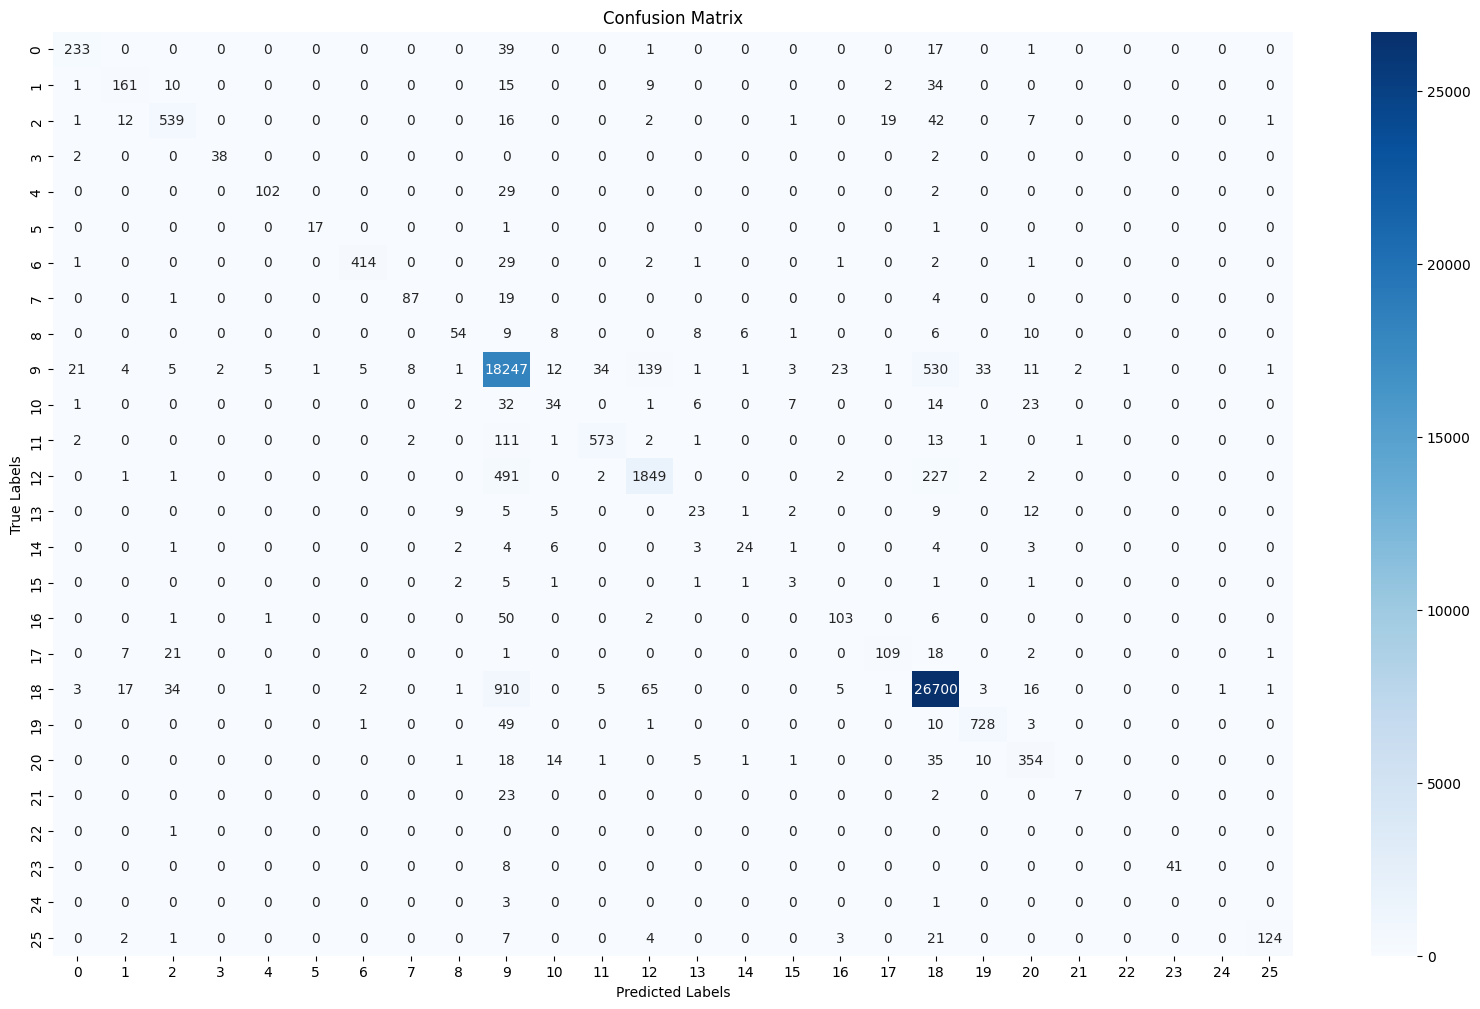

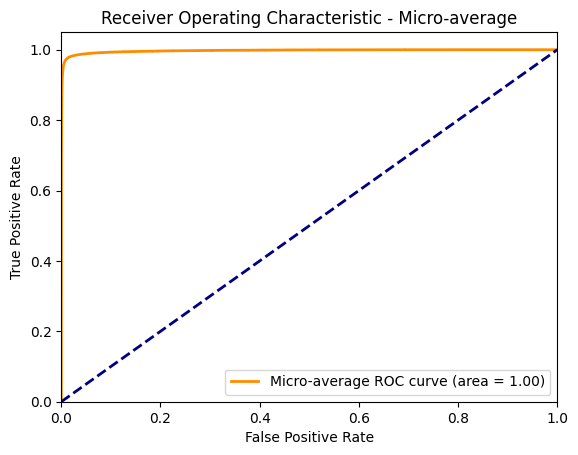

In [31]:

# Open a file to write the outputs
with open('res/results.txt', 'w') as f:

    # Convert accumulated predictions and labels to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # Determine the unique classes in y_true and binarize
    classes = np.unique(y_true)  # Identify unique class labels
    y_true_binarized = label_binarize(y_true, classes=classes)

    n_classes = len(classes)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, average="weighted", labels=classes)
    recall = recall_score(y_true, y_pred, average="weighted", labels=classes)
    f1 = f1_score(y_true, y_pred, average="weighted", labels=classes)

    # ROC Curve and AUC for Micro-average
    fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # Print and write metrics to file
    metrics_output = f"OVERALL METRICS\nAccuracy: {accuracy * 100:.2f}%\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\n"
    print(metrics_output)
    f.write(metrics_output)

    # Calculate accuracy by class
    accuracies_by_class = {}
    for cls in classes:
        idx = np.where(y_true == cls)[0]
        accuracy_cls = accuracy_score(y_true[idx], y_pred[idx])
        accuracies_by_class[cls] = accuracy_cls

    # Print and write accuracy by class to file
    f.write("\nACCURACY BY CLASS\n")
    for cls, acc in accuracies_by_class.items():
        class_output = f'{class_list[cls]} (class {cls}): {acc * 100:.2f}%\n'
        print(class_output)
        f.write(class_output)

    # Calculate and visualize the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(20, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('res/confusion_matrix.png')
    plt.show()

    # Plot ROC Curve for Micro-average
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Micro-average')
    plt.legend(loc='lower right')
    plt.show()